In [1]:
from bs4 import BeautifulSoup
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import re
import requests
import scipy.stats as stats
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ea = pd.read_csv('educational_attainment.csv')
ei = pd.read_csv('education_income_simple.csv')
df = pd.merge(ei, ea, on='county')
df.dtypes

county        object
pop_income     int64
lh_income      int64
hs_income      int64
aa_income      int64
ba_income      int64
ma_income      int64
pop            int64
less_hs        int64
some_hs        int64
hs             int64
sc             int64
aa             int64
ba             int64
ma             int64
dtype: object

In [3]:
df['he_pct'] = ((df['ba']+df['ma'])/df['pop'])*100

In [4]:
df['le_income'] = (df['lh_income'] * ((df['less_hs'] + df['some_hs']) / df['pop']) + df['hs_income'] * (df['hs'] / df['pop']) + df['aa_income'] * ((df['sc'] + df['aa']) / df['pop'])) / ((df['less_hs'] + df['some_hs'] + df['hs'] + df['sc'] + df['aa']) / df['pop'])
df['he_income'] = ((df['ba_income'] * (df['ba'] / df['pop'])) + (df['ma_income'] * (df['ma'] / df['pop']))) / ((df['ba'] + df['ma']) / df['pop'])

In [5]:
dfa = df[['county', 'le_income', 'he_pct', 'he_income', 'pop']]
dfa.corr()

,le_income,he_pct,he_income,pop
le_income,1.000000,0.428738,0.588716,0.121412
he_pct,0.428738,1.000000,0.525885,0.334500
he_income,0.588716,0.525885,1.000000,0.355924
pop,0.121412,0.334500,0.355924,1.000000


In [6]:
y, x = patsy.dmatrices('le_income ~ he_pct', data=df)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     672.0
Date:                Mon, 15 Oct 2018   Prob (F-statistic):          8.30e-134
Time:                        12:50:17   Log-Likelihood:                -28878.
No. Observations:                2986   AIC:                         5.776e+04
Df Residuals:                    2984   BIC:                         5.777e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.427e+04    175.611    138.180      0.000    2.39e+04    2.46e+04
he_pct       200.0280      7.716     25.924      0.000     184.899     215.157
==============================================================================
Omnibus:                      300.250   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              807.845
Skew:                           0.558   Prob(JB):                    3.79e-176
Kurtosis:                       5.291   Cond. No.                         57.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Income for those with Less than Bachelors')

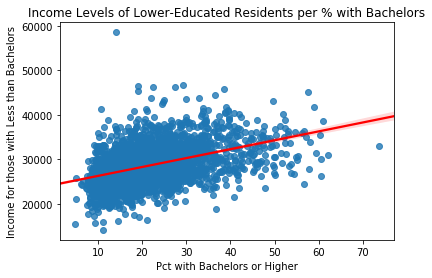

In [7]:
sns.regplot(df['he_pct'], df['le_income'], line_kws={"color": "red"})
plt.title("Income Levels of Lower-Educated Residents per % with Bachelors")
plt.xlabel("Pct with Bachelors or Higher")
plt.ylabel("Income for those with Less than Bachelors")

In [8]:
model = Lasso(1.0)
fit = model.fit(x, y)
fit

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [9]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income', data=df)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     861.8
Date:                Mon, 15 Oct 2018   Prob (F-statistic):          4.02e-296
Time:                        12:50:17   Log-Likelihood:                -28501.
No. Observations:                2986   AIC:                         5.701e+04
Df Residuals:                    2983   BIC:                         5.703e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.42e+04    376.918     37.665      0.000    1.35e+04    1.49e+04
he_pct        76.8342      7.995      9.610      0.000      61.157      92.511
he_income      0.2675      0.009     29.299      0.000       0.250       0.285
==============================================================================
Omnibus:                      170.572   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.753
Skew:                           0.336   Prob(JB):                     1.43e-90
Kurtosis:                       4.695   Cond. No.                     2.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Income Levels of Lower-Educated Residents per Income Level of Higher-Educated Residents')

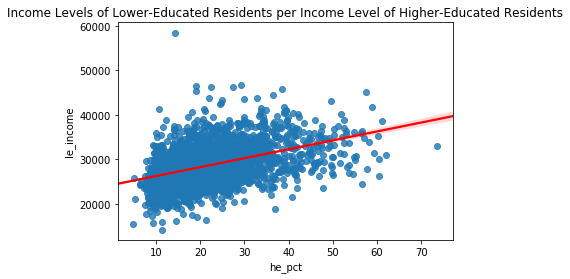

In [10]:
sns.regplot(df['he_pct'], df['le_income'], line_kws={"color": "red"})
plt.title("Income Levels of Lower-Educated Residents per Income Level of Higher-Educated Residents")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


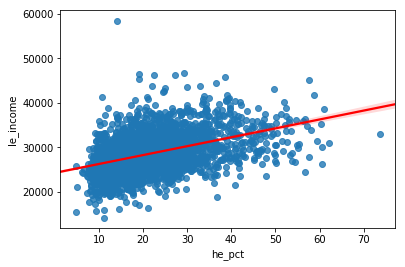

In [11]:
sns.regplot(df['he_pct'], df['le_income'], line_kws={"color": "red"})

In [12]:
ind = pd.read_csv('economic_industry.csv')
ind

,county,employed,agricultural,mining,construction,manufacturing
0,"Autauga County, Alabama",24262,157,137,1167,3396
1,"Baldwin County, Alabama",87753,828,440,6777,8106
2,"Barbour County, Alabama",8993,392,15,567,2015
3,"Bibb County, Alabama",8354,49,278,682,1766
4,"Blount County, Alabama",21593,474,147,2056,3362
5,"Bullock County, Alabama",4174,532,0,188,1077
6,"Butler County, Alabama",7810,273,18,582,1606
7,"Calhoun County, Alabama",47010,448,47,2739,7926
8,"Chambers County, Alabama",14031,197,18,651,3803
9,"Cherokee County, Alabama",10193,200,0,761,2307


In [13]:
ind['industrial'] = ind['mining'] + ind['construction'] + ind['manufacturing']
ind['service'] = ind['employed'] - ind['agricultural'] - ind['industrial']
ind['ag_pct'] = (ind['agricultural'] / ind['employed']) * 100
ind['ind_pct'] = (ind['industrial'] / ind['employed']) * 100
ind['svc_pct'] = (ind['service'] / ind['employed']) * 100
ind1 = ind[['county', 'employed', 'ag_pct', 'ind_pct', 'svc_pct']]
df1 = pd.merge(dfa, ind1, on='county')
df1

,county,le_income,he_pct,he_income,pop,employed,ag_pct,ind_pct,svc_pct
0,"Santa Clara County, California",34177.436877,49.103299,91174.746907,1284765,938545,0.547763,23.028091,76.424146
1,"San Jacinto County, Texas",27447.033037,10.005271,60082.037935,18970,10514,1.959292,29.779342,68.261366
2,"North Slope Borough, Alaska",58478.804685,14.181703,91115.513393,6318,5393,0.908585,38.920823,60.170592
3,"Concho County, Texas",23373.208000,11.490183,49492.899160,3107,1056,15.625000,19.034091,65.340909
4,"San Mateo County, California",35455.944766,47.051365,81384.402209,535502,395999,0.491920,12.969730,86.538350
5,"Fairfax County, Virginia",35358.988845,60.260099,86039.063246,768784,606244,0.138558,8.502352,91.359090
6,"Loudoun County, Virginia",41668.208281,58.840119,89610.018708,230834,194071,0.496725,9.451696,90.051579
7,"Somerset County, New Jersey",36456.403699,52.965450,84323.385663,228768,172259,0.229886,16.680696,83.089418
8,"Stafford County, Virginia",39690.154794,37.333197,81663.460920,87903,65669,0.152279,10.517900,89.329821
9,"Arlington County, Virginia",32972.672033,73.664560,86414.838071,169813,142212,0.096335,6.563440,93.340224


In [14]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct', data=df1)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     631.1
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:50:18   Log-Likelihood:                -28266.
No. Observations:                2986   AIC:                         5.654e+04
Df Residuals:                    2981   BIC:                         5.657e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6911.1203    476.014     14.519      0.000    5977.771    7844.470
he_pct       165.8655      8.515     19.480      0.000     149.170     182.560
he_income      0.2756      0.009     31.479      0.000       0.258       0.293
ag_pct       169.0167     11.161     15.144      0.000     147.133     190.900
ind_pct      198.8613      9.758     20.380      0.000     179.729     217.993
==============================================================================
Omnibus:                      172.928   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              462.080
Skew:                           0.308   Prob(JB):                    4.58e-101
Kurtosis:                       4.826   Cond. No.                     3.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


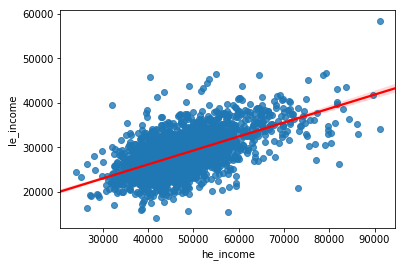

In [15]:
sns.regplot(df1['he_income'], df1['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


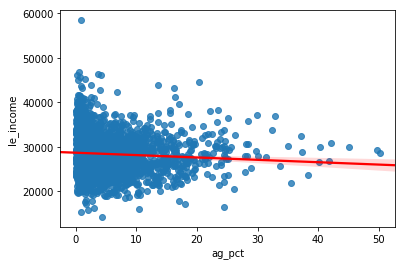

In [16]:
sns.regplot(df1['ag_pct'], df1['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


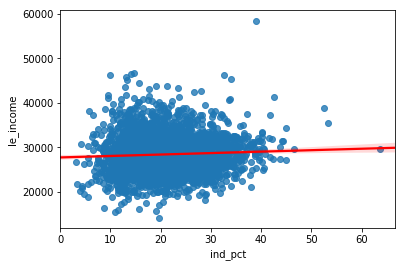

In [17]:
sns.regplot(df1['ind_pct'], df1['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


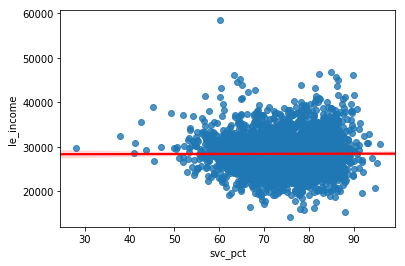

In [18]:
sns.regplot(df1['svc_pct'], df1['le_income'], line_kws={"color": "red"})

In [19]:
ce = pd.read_csv('county_employers.csv')
df2 = pd.merge(df1, ce, on='county')
df2['popest'] = df2['pop']/df2['establishments']
df2

,county,le_income,he_pct,he_income,pop,employed,ag_pct,ind_pct,svc_pct,establishments,popest
0,"Santa Clara County, California",34177.436877,49.103299,91174.746907,1284765,938545,0.547763,23.028091,76.424146,48278,26.611811
1,"San Jacinto County, Texas",27447.033037,10.005271,60082.037935,18970,10514,1.959292,29.779342,68.261366,192,98.802083
2,"North Slope Borough, Alaska",58478.804685,14.181703,91115.513393,6318,5393,0.908585,38.920823,60.170592,157,40.242038
3,"Concho County, Texas",23373.208000,11.490183,49492.899160,3107,1056,15.625000,19.034091,65.340909,51,60.921569
4,"San Mateo County, California",35455.944766,47.051365,81384.402209,535502,395999,0.491920,12.969730,86.538350,21199,25.260720
5,"Fairfax County, Virginia",35358.988845,60.260099,86039.063246,768784,606244,0.138558,8.502352,91.359090,30921,24.862844
6,"Loudoun County, Virginia",41668.208281,58.840119,89610.018708,230834,194071,0.496725,9.451696,90.051579,10175,22.686388
7,"Somerset County, New Jersey",36456.403699,52.965450,84323.385663,228768,172259,0.229886,16.680696,83.089418,9970,22.945637
8,"Stafford County, Virginia",39690.154794,37.333197,81663.460920,87903,65669,0.152279,10.517900,89.329821,2278,38.587796
9,"Arlington County, Virginia",32972.672033,73.664560,86414.838071,169813,142212,0.096335,6.563440,93.340224,6344,26.767497


In [20]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest', data=df2)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     515.9
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:50:20   Log-Likelihood:                -28214.
No. Observations:                2983   AIC:                         5.644e+04
Df Residuals:                    2977   BIC:                         5.648e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8521.3272    537.015     15.868      0.000    7468.369    9574.285
he_pct       134.9587      9.677     13.946      0.000     115.984     153.934
he_income      0.2826      0.009     32.275      0.000       0.265       0.300
ag_pct       150.5602     11.429     13.174      0.000     128.151     172.969
ind_pct      190.8397      9.764     19.544      0.000     171.694     209.985
popest       -30.4774      4.985     -6.114      0.000     -40.252     -20.703
==============================================================================
Omnibus:                      174.566   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.887
Skew:                           0.336   Prob(JB):                     3.68e-95
Kurtosis:                       4.745   Cond. No.                     4.53e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


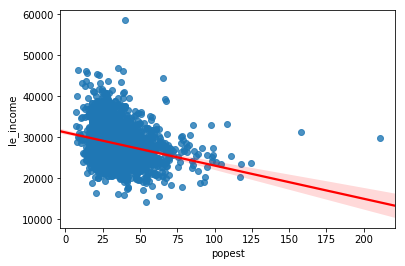

In [21]:
sns.regplot(df2['popest'], df2['le_income'], line_kws={"color": "red"})

In [22]:
lf = pd.read_csv('education_laborforce.csv')
lf['lelf'] = ((lf['lhlf'] + lf['hslf'] + lf['sclf'])/(lf['pop2564']-lf['bapop']))*100
lf['leue'] = ((lf['lhue'] + lf['hsue'] + lf['scue'])/(lf['lhlfc'] + lf['hslfc'] + lf['sclfc']))*100
lf['helf'] = (lf['balf']/lf['bapop']) * 100
lf['heue'] = (lf['baue']/lf['balfc']) * 100
lf['lftotal'] = ((lf['lhlf'] + lf['hslf'] + lf['sclf'] + lf['balf'])/lf['pop2564'])*100
lf = lf[['county', 'lelf', 'leue', 'helf', 'heue', 'lftotal']]

In [23]:
df3 = pd.merge(df2, lf, on='county')
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest + lelf + leue + lftotal', data=df3)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     560.3
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:50:20   Log-Likelihood:                -27774.
No. Observations:                2983   AIC:                         5.557e+04
Df Residuals:                    2974   BIC:                         5.562e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4951.9238    766.761      6.458      0.000    3448.487    6455.360
he_pct        27.5651      9.721      2.836      0.005       8.504      46.626
he_income      0.2524      0.008     32.547      0.000       0.237       0.268
ag_pct        -6.7592     11.065     -0.611      0.541     -28.454      14.936
ind_pct       57.3885      9.425      6.089      0.000      38.908      75.869
popest        32.8394      4.781      6.869      0.000      23.465      42.214
lelf         180.6978     43.611      4.143      0.000      95.186     266.209
leue        -374.1957     19.286    -19.403      0.000    -412.010    -336.381
lftotal      -21.6316     47.455     -0.456      0.649    -114.680      71.417
==============================================================================
Omnibus:                      412.126   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1338.001
Skew:                           0.695   Prob(JB):                    2.86e-291
Kurtosis:                       5.972   Cond. No.                     7.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


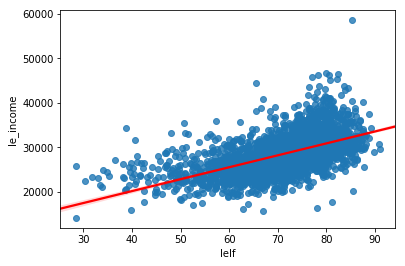

In [24]:
sns.regplot(df3['lelf'], df3['le_income'], line_kws={"color": "red"})

In [25]:
df3a = df3.drop(['county', 'heue', 'helf', 'lftotal'], axis=1)
lr = LinearRegression()
X = df3a.iloc[:,1:]
y = df3a.iloc[:,0]
lr.fit(X, y)
lr.score(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


0.605831243525572

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


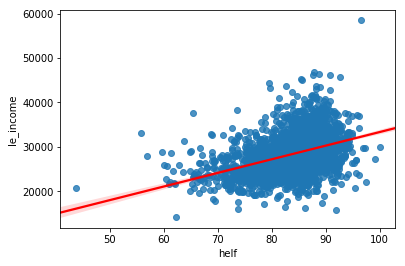

In [26]:
sns.regplot(df3['helf'], df3['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


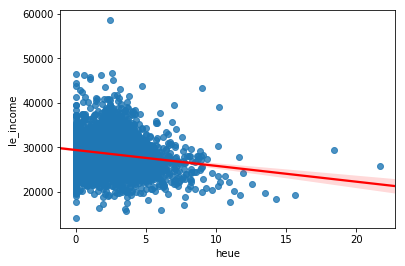

In [27]:
sns.regplot(df3['heue'], df3['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


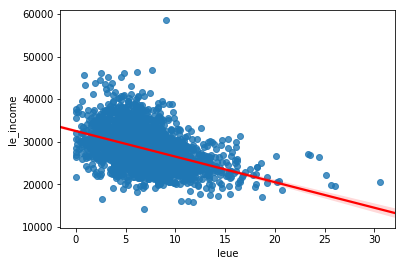

In [28]:
sns.regplot(df3['leue'], df3['le_income'], line_kws={"color": "red"})

In [29]:
mw = pd.read_csv('county_minwage.csv')
df4 = pd.merge(df3,mw,on='county')
df4

,county,le_income,he_pct,he_income,pop,employed,ag_pct,ind_pct,svc_pct,establishments,popest,lelf,leue,helf,heue,lftotal,wage
0,"Santa Clara County, California",34177.436877,49.103299,91174.746907,1284765,938545,0.547763,23.028091,76.424146,48278,26.611811,76.707454,7.937486,84.705536,4.129976,80.804767,10.00
1,"San Jacinto County, Texas",27447.033037,10.005271,60082.037935,18970,10514,1.959292,29.779342,68.261366,192,98.802083,67.835522,7.452480,70.605760,2.812940,68.038759,7.25
2,"North Slope Borough, Alaska",58478.804685,14.181703,91115.513393,6318,5393,0.908585,38.920823,60.170592,157,40.242038,85.302252,9.048616,96.491228,2.467532,86.825939,9.75
3,"Concho County, Texas",23373.208000,11.490183,49492.899160,3107,1056,15.625000,19.034091,65.340909,51,60.921569,31.741701,2.578797,69.076305,1.744186,35.539216,7.25
4,"San Mateo County, California",35455.944766,47.051365,81384.402209,535502,395999,0.491920,12.969730,86.538350,21199,25.260720,79.836514,5.887278,86.600774,3.734730,83.169915,10.00
5,"Fairfax County, Virginia",35358.988845,60.260099,86039.063246,768784,606244,0.138558,8.502352,91.359090,30921,24.862844,80.959115,5.090954,87.332154,2.787396,84.881945,7.25
6,"Loudoun County, Virginia",41668.208281,58.840119,89610.018708,230834,194071,0.496725,9.451696,90.051579,10175,22.686388,82.962376,3.894677,88.004013,2.703830,86.049831,7.25
7,"Somerset County, New Jersey",36456.403699,52.965450,84323.385663,228768,172259,0.229886,16.680696,83.089418,9970,22.945637,80.696770,5.695232,86.324254,3.692481,83.876001,8.38
8,"Stafford County, Virginia",39690.154794,37.333197,81663.460920,87903,65669,0.152279,10.517900,89.329821,2278,38.587796,75.712089,4.496775,86.980208,1.905806,80.059599,7.25
9,"Arlington County, Virginia",32972.672033,73.664560,86414.838071,169813,142212,0.096335,6.563440,93.340224,6344,26.767497,77.590254,5.116517,90.673396,2.367481,87.525131,7.25


In [30]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest + lelf + leue + helf + heue + wage', data=df4)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     460.1
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:50:22   Log-Likelihood:                -27750.
No. Observations:                2983   AIC:                         5.552e+04
Df Residuals:                    2972   BIC:                         5.559e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    638.2606   1028.247      0.621      0.535   -1377.888    2654.409
he_pct        29.0147      9.057      3.204      0.001      11.257      46.772
he_income      0.2413      0.008     31.005      0.000       0.226       0.257
ag_pct       -13.8823     11.112     -1.249      0.212     -35.669       7.905
ind_pct       66.7809      9.449      7.068      0.000      48.254      85.308
popest        36.1810      4.764      7.595      0.000      26.841      45.521
lelf         147.5881      8.639     17.085      0.000     130.650     164.526
leue        -385.5755     19.784    -19.489      0.000    -424.367    -346.784
helf          24.4927     10.986      2.229      0.026       2.952      46.033
heue         -22.8790     27.803     -0.823      0.411     -77.394      31.636
wage         430.5952     65.246      6.600      0.000     302.663     558.528
==============================================================================
Omnibus:                      413.515   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.857
Skew:                           0.714   Prob(JB):                    1.09e-276
Kurtosis:                       5.861   Cond. No.                     1.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
lr = LinearRegression()
X = df4[['he_pct', 'he_income', 'ag_pct', 'ind_pct', 'popest', 'lelf', 'leue', 'helf', 'heue', 'wage']]
y = df4['le_income']
lr.fit(X, y)
lr.score(X, y)

0.6075415735665364

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5886690507729498

In [33]:
lr = LinearRegression()
scores = cross_val_score(lr, X, y, cv=10, scoring='mean_squared_error')

print('Mean squarer error for each cross-val:',scores,'\n')
print('Mean squared error of all cross vals:',np.mean(scores),'+-',np.std(scores))

Mean squarer error for each cross-val: [-12445396.86219263  -7862769.09322891  -7230997.98088404
  -5877124.77740704  -5093136.91481625  -4583995.66024417
  -5985163.12133015  -6257899.54072709  -6939582.4012525
  -9894364.4404101 ] 

Mean squared error of all cross vals: -7217043.079249287 +- 2251103.1944950833


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was re

In [53]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest + lelf + leue + helf + heue + wage', data=df4)
model = sm.OLS(y, x)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              le_income   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     460.1
Date:                Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                        13:05:35   Log-Likelihood:                -27750.
No. Observations:                2983   AIC:                         5.552e+04
Df Residuals:                    2972   BIC:                         5.559e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    638.2606   1028.247      0.621      0.535   -1377.888    2654.409
he_pct        29.0147      9.057      3.204      0.001      11.257      46.772
he_income      0.2413      0.008     31.005      0.000       0.226       0.257
ag_pct       -13.8823     11.112     -1.249      0.212     -35.669       7.905
ind_pct       66.7809      9.449      7.068      0.000      48.254      85.308
popest        36.1810      4.764      7.595      0.000      26.841      45.521
lelf         147.5881      8.639     17.085      0.000     130.650     164.526
leue        -385.5755     19.784    -19.489      0.000    -424.367    -346.784
helf          24.4927     10.986      2.229      0.026       2.952      46.033
heue         -22.8790     27.803     -0.823      0.411     -77.394      31.636
wage         430.5952     65.246      6.600      0.000     302.663     558.528
==============================================================================
Omnibus:                      413.515   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1270.857
Skew:                           0.714   Prob(JB):                    1.09e-276
Kurtosis:                       5.861   Cond. No.                     1.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


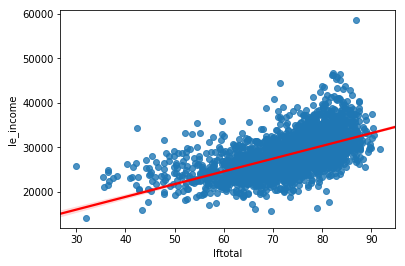

In [35]:
sns.regplot(df4['lftotal'], df4['le_income'], line_kws={"color": "red"})

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


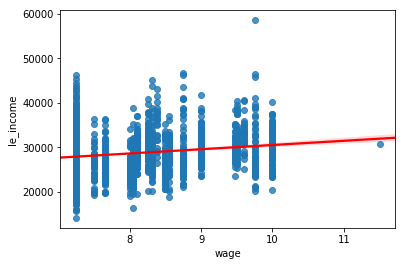

In [36]:
sns.regplot(df4['wage'], df4['le_income'], line_kws={"color": "red"})

In [40]:
print('Training score: {}'.format(lr.score(X_train, y_train)))
print('Test score: {}'.format(lr.score(X_test, y_test)))

Training score: 0.6143003095030592
Test score: 0.5886690507729498


In [38]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=10, scoring='mean_squared_error')
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [-12445396.86219263  -7862769.09322891  -7230997.98088404
  -5877124.77740704  -5093136.91481625  -4583995.66024417
  -5985163.12133015  -6257899.54072709  -6939582.4012525
  -9894364.4404101 ] 

Mean Rˆ2 of all cross vals: -7217043.079249287 +- 2251103.1944950833


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was re

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.6143003095030592
0.5886690507729498


In [ ]:
df4['lelf2'] = df4['lelf']**2
df4['leue2'] = df4['leue']**2
df4['popest2'] = df4['popest']**2
lr = LinearRegression()
X = df4[['he_pct', 'he_income', 'ag_pct', 'ind_pct', 'popest', 'leue2', 'lelf2', 'lelf', 'leue', 'helf', 'heue', 'lftotal', 'wage']]
y = df4['le_income']
fit = lr.fit(X, y)
score = lr.score(X, y)
score

In [55]:
df4['predict'] = lr.predict(X)
df4['residual'] = df4.le_income-df4.predict

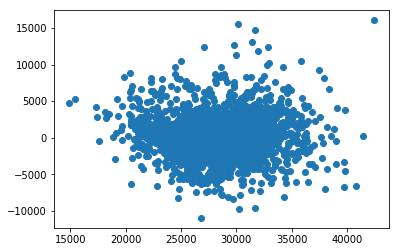

In [56]:
p = df4['predict']
r = df4['residual']
plt.scatter(p,r)

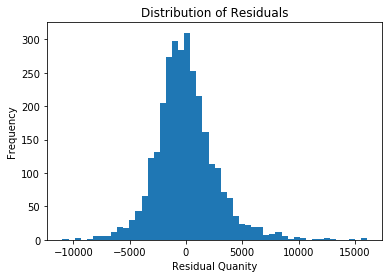

In [57]:
plt.hist(r, bins=50)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Quanity")
plt.ylabel("Frequency");

In [ ]:
df4.corr()

In [ ]:
scores = cross_val_score(lr, X, y, cv=10, scoring='mean_squared_error')
print('MSE for each cross-val:',scores,'\n')
print('MSE of all cross vals:',np.mean(scores),'+-',np.std(scores))

In [ ]:
ri = RidgeCV(alphas=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
rifit = ri.fit(X, y)
rifit.score(X, y)

In [ ]:
la = Lasso(alpha=1)
lafit = la.fit(X, y)
lafit.score(X, y)

In [ ]:
scores = cross_val_score(ri, X, y, cv=10, scoring='mean_squared_error')
print('MSE for each cross-val:',scores,'\n')
print('MSE of all cross vals:',np.mean(scores),'+-',np.std(scores))

In [ ]:
scores = cross_val_score(la, X, y, cv=10, scoring='mean_squared_error')
print('MSE for each cross-val:',scores,'\n')
print('MSE of all cross vals:',np.mean(scores),'+-',np.std(scores))

In [ ]:
y, x = patsy.dmatrices('le_income ~ he_pct + he_income + ag_pct + ind_pct + popest + lelf + leue + helf + heue + wage', data=df4)
modelridge = sm.OLS.fit_regularized(y, x, method='elastic_net')
fitridge = modelridge.fit()
fitridge.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
ri.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
la.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))